In [102]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
from datetime import datetime
import networkx as nx

# Add parent directory to path to import local modules
sys.path.insert(0, str(Path.cwd().parent))

from src.behavior_import.import_data import *
from src.behavior_import.extract_trials import *

cohort1_data = import_data("../data/cohort-2/rawdata")

[INFO] Built 6 subject(s), 78 session(s).


In [101]:
cohort1_data = import_data("../data/cohort-2/rawdata")

[INFO] Built 6 subject(s), 78 session(s).


In [80]:
cohort1_subject_ids = list(cohort1_data.keys())
cohort2_subject_ids = list(cohort2_data.keys())

In [81]:
# Sort all subjects' sessions
cohort1_data_by_problem = {}
for subject_id, sessions in cohort1_data.items():
    cohort1_data_by_problem[subject_id] = sort_sessions_by_problem_and_date(sessions)
    print(f"\n{subject_id}:")
    for problem_key in sorted(cohort1_data_by_problem[subject_id].keys()):
        problem_sessions = cohort1_data_by_problem[subject_id][problem_key]
        print(f"  {problem_key}: {len(problem_sessions)} sessions")
        
        # Print date range
        if problem_sessions:
            first_date = get_session_date(problem_sessions[0][1])
            last_date = get_session_date(problem_sessions[-1][1])
            problem_sig = get_problem_signature(problem_sessions[0][1])
            print(f"    Problem: {problem_sig}")
            print(f"    Date range: {first_date.date()} to {last_date.date()}")


MY_300_N:
  problem_1: 6 sessions
    Problem: A1_A3_C3|B2
    Date range: 2025-10-27 to 2025-10-29

MY_299_N:
  problem_1: 6 sessions
    Problem: A1_A3_C3|B2
    Date range: 2025-10-27 to 2025-10-29


In [82]:
# Sort all subjects' sessions
cohort2_data_by_problem = {}
for subject_id, sessions in cohort2_data.items():
    cohort2_data_by_problem[subject_id] = sort_sessions_by_problem_and_date(sessions)
    print(f"\n{subject_id}:")
    for problem_key in sorted(cohort2_data_by_problem[subject_id].keys()):
        problem_sessions = cohort2_data_by_problem[subject_id][problem_key]
        print(f"  {problem_key}: {len(problem_sessions)} sessions")
        
        # Print date range
        if problem_sessions:
            first_date = get_session_date(problem_sessions[0][1])
            last_date = get_session_date(problem_sessions[-1][1])
            problem_sig = get_problem_signature(problem_sessions[0][1])
            print(f"    Problem: {problem_sig}")
            print(f"    Date range: {first_date.date()} to {last_date.date()}")

In [83]:
import pandas as pd
from typing import Any, Iterable

# =============================================================================
# ONLY aliases you’ve actually shown in your files (old/new)
# =============================================================================

REVERSAL_ALIASES = {
    # reversals (per-session counters in your flattened df)
    "good": ("num_good_reversals", "num_good_rev"),
    "bad":  ("num_bad_reversals",  "num_bad_rev"),

    # blocks (used by fallback methods)
    "blocks": ("num_blocks", "num_blocks"),
}

# =============================================================================
# Small helpers
# =============================================================================

def coalesce_col(df: pd.DataFrame, old_new: tuple[str, str]) -> pd.Series:
    """
    Return df[new] if present else df[old] if present else all-NA series.
    Prefers the NEW name when available.
    """
    old, new = old_new
    if new in df.columns:
        return df[new]
    if old in df.columns:
        return df[old]
    return pd.Series([pd.NA] * len(df), index=df.index)

def max_counter(df: pd.DataFrame, old_new: tuple[str, str]):
    """
    Return max of a counter column (prefers new name), or NA if missing/all NA.
    """
    s = coalesce_col(df, old_new)
    if s.isna().all():
        return pd.NA
    return s.max(skipna=True)

def any_present(df: pd.DataFrame, old_new: tuple[str, str]) -> bool:
    """True if either alias column exists in df."""
    old, new = old_new
    return (new in df.columns) or (old in df.columns)

# =============================================================================
# Your function (alias-aware)
# =============================================================================

def compute_problem_statistics(data_by_problem, problem_key='problem_1', debug=False):
    """
    Compute reversal and block statistics for a specific problem across all subjects.

    Tries to extract good/bad reversals using ONLY the aliases you’ve seen:
      - good: num_good_reversals / num_good_rev
      - bad:  num_bad_reversals  / num_bad_rev

    If those counters aren't available (or all NA), falls back to counting reversals
    as number of blocks - 1 (via your existing helper functions).

    Returns:
        dict with keys:
            - 'total_reversals': {subject_id: total_reversals}
            - 'good_reversals': {subject_id: good_reversals}  (if available)
            - 'bad_reversals': {subject_id: bad_reversals}    (if available)
            - 'reversals_per_session': {subject_id: [reversals_per_session]}
            - 'good_reversals_per_session': {subject_id: [good_reversals_per_session]} (if available)
            - 'bad_reversals_per_session': {subject_id: [bad_reversals_per_session]}   (if available)
            - 'block_lengths': {subject_id: [block_lengths]}
    """
    stats = {
        'total_reversals': {},
        'good_reversals': {},
        'bad_reversals': {},
        'reversals_per_session': {},
        'good_reversals_per_session': {},
        'bad_reversals_per_session': {},
        'block_lengths': {}
    }

    subjects = list(data_by_problem.keys())
    first_subject = subjects[0] if subjects else None

    for subject_id, problems in data_by_problem.items():
        if problem_key not in problems:
            continue

        # Extract session DataFrames for this problem
        session_dfs = [session_dict['data'] for _, session_dict in problems[problem_key]]

        good_reversals = 0
        bad_reversals = 0
        has_good_bad_data = False
        good_reversals_list = []
        bad_reversals_list = []

        if debug and subject_id == first_subject:
            print(f"\nDebug {subject_id} in {problem_key}:")
            print(f"  Number of sessions: {len(session_dfs)}")

        for sess_idx, df in enumerate(session_dfs):
            if debug and subject_id == first_subject and sess_idx == 0:
                print("  Session 0 has good/bad columns: ", end="")
                print(
                    f"good={any_present(df, REVERSAL_ALIASES['good'])}, "
                    f"bad={any_present(df, REVERSAL_ALIASES['bad'])}"
                )

            # Alias-aware extraction (max of cumulative counters)
            good_val = max_counter(df, REVERSAL_ALIASES["good"])
            bad_val  = max_counter(df, REVERSAL_ALIASES["bad"])

            if debug and subject_id == first_subject and sess_idx == 0:
                print(f"    Max good_val: {good_val}, Max bad_val: {bad_val}")
                print(f"    pd.notna(good_val): {pd.notna(good_val)}, pd.notna(bad_val): {pd.notna(bad_val)}")

            if pd.notna(good_val) and pd.notna(bad_val):
                has_good_bad_data = True
                good_val_int = int(good_val)
                bad_val_int = int(bad_val)

                good_reversals += good_val_int
                bad_reversals += bad_val_int
                good_reversals_list.append(good_val_int)
                bad_reversals_list.append(bad_val_int)

                if debug and subject_id == first_subject:
                    print(f"    Session {sess_idx}: Added good={good_val_int}, bad={bad_val_int}")

        # If we found good/bad reversal data, use it
        if has_good_bad_data:
            stats['good_reversals'][subject_id] = good_reversals
            stats['bad_reversals'][subject_id] = bad_reversals
            stats['total_reversals'][subject_id] = good_reversals + bad_reversals
            stats['good_reversals_per_session'][subject_id] = good_reversals_list
            stats['bad_reversals_per_session'][subject_id] = bad_reversals_list

            if debug and subject_id == first_subject:
                print(f"  Total for {subject_id}: good={good_reversals}, bad={bad_reversals}, total={good_reversals + bad_reversals}")
        else:
            # Fall back to your original method (these functions must exist in your notebook)
            total_rev = count_total_reversals(session_dfs)
            stats['total_reversals'][subject_id] = total_rev

            if debug and subject_id == first_subject:
                print(f"  Fallback for {subject_id}: total_reversals={total_rev}")

        # These functions must exist in your notebook already
        rev_per_session = count_reversals_per_session(session_dfs)
        stats['reversals_per_session'][subject_id] = rev_per_session

        block_lengths = block_duration_distribution(session_dfs)
        stats['block_lengths'][subject_id] = block_lengths

    return stats


# =============================================================================
# Example usage (as in your notebook)
# =============================================================================
problem1_stats = compute_problem_statistics(cohort1_data_by_problem, 'problem_1')
print("\nCohort 1 Problem 1 Statistics:")
print(f"  Subjects: {list(problem1_stats['total_reversals'].keys())}")
print(f"  Good reversals: {problem1_stats['total_reversals']}")

problem1_stats = compute_problem_statistics(cohort2_data_by_problem, 'problem_1')
print("\nCohort 2 Problem 1 Statistics:")
print(f"  Subjects: {list(problem1_stats['total_reversals'].keys())}")
print(f"  Good reversals: {problem1_stats['good_reversals']}")
print(f"  Bad reversals: {problem1_stats['bad_reversals']}")


Cohort 1 Problem 1 Statistics:
  Subjects: ['MY_300_N', 'MY_299_N']
  Good reversals: {'MY_300_N': 3, 'MY_299_N': 1}

Cohort 2 Problem 1 Statistics:
  Subjects: []
  Good reversals: {}
  Bad reversals: {}


In [84]:
desired_order = [
    "MY_04_N", "MY_04_L",
    "MY_04_R", "MY_05_N",
    "MY_05_L", "MY_05_R"
]

In [85]:
import matplotlib.pyplot as plt
import numpy as np

def make_subject_colors(subject_ids, cmap_name="tab10"):
    """
    Create a stable subject → color mapping.
    """
    cmap = plt.get_cmap(cmap_name)
    n = max(len(subject_ids), cmap.N)

    return {
        subj: cmap(i % cmap.N)
        for i, subj in enumerate(subject_ids)
    }

subject_colors = make_subject_colors(desired_order)


Cohort 1 problem 1:
  Subjects: ['MY_300_N', 'MY_299_N']
  Total reversals: {'MY_300_N': 3, 'MY_299_N': 1}

Cohort 2 problem 1:
  Subjects: []
  Good reversals: {}
  Bad reversals: {}


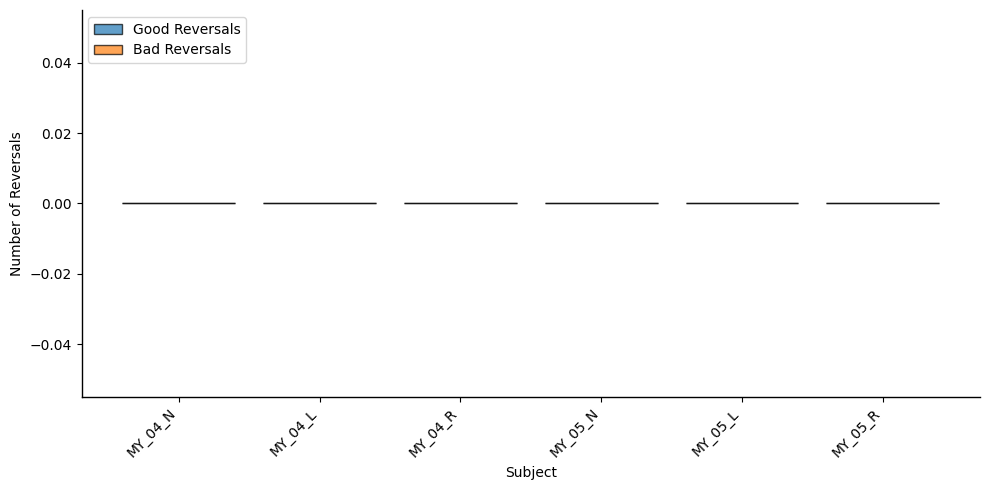

In [86]:
import numpy as np
import matplotlib.pyplot as plt

def combine_cohort_stats_for_stacked_plot(
    cohort1_stats: dict,
    cohort2_stats: dict,
) -> dict:
    """
    Make a single 'problem3-style' stats dict with:
      - good_reversals
      - bad_reversals
      - total_reversals

    Rule:
      - Cohort 1 only has totals -> treat as GOOD, set BAD = 0.
      - Cohort 2 has good/bad -> use them.
    """
    out = {
        "good_reversals": {},
        "bad_reversals": {},
        "total_reversals": {},
    }

    # Cohort 1: total -> good
    c1_total = cohort1_stats.get("total_reversals", {})
    for subj, tot in c1_total.items():
        tot = int(tot) if tot is not None else 0
        out["good_reversals"][subj] = tot
        out["bad_reversals"][subj] = 0
        out["total_reversals"][subj] = tot

    # Cohort 2: good/bad if present; otherwise fall back to total
    c2_good = cohort2_stats.get("good_reversals", {})
    c2_bad  = cohort2_stats.get("bad_reversals", {})
    c2_total = cohort2_stats.get("total_reversals", {})

    all_c2_subjs = set(c2_total.keys()) | set(c2_good.keys()) | set(c2_bad.keys())
    for subj in all_c2_subjs:
        g = c2_good.get(subj, None)
        b = c2_bad.get(subj, None)

        if g is None and b is None:
            # fallback: if only total exists
            tot = int(c2_total.get(subj, 0) or 0)
            g, b = tot, 0
        else:
            g = int(g or 0)
            b = int(b or 0)

        out["good_reversals"][subj] = g
        out["bad_reversals"][subj] = b
        out["total_reversals"][subj] = g + b

    return out

def plot_total_reversals(
    stats: dict,
    desired_order,
    title="Total Reversals per Subject",
    *,
    stacked_good_bad: bool = False,
):
    """
    If stacked_good_bad=True, expects stats to have:
      - good_reversals
      - bad_reversals
    Otherwise uses stats['total_reversals'].
    """
    fig, ax = plt.subplots(figsize=(10, 5))

    x_pos = np.arange(len(desired_order))

    if stacked_good_bad:
        good_values = [int(stats.get("good_reversals", {}).get(subj, 0) or 0) for subj in desired_order]
        bad_values  = [int(stats.get("bad_reversals",  {}).get(subj, 0) or 0) for subj in desired_order]

        ax.bar(x_pos, good_values, alpha=0.7, label="Good Reversals", edgecolor="black")
        ax.bar(x_pos, bad_values, bottom=good_values, alpha=0.7, label="Bad Reversals", edgecolor="black")
        ax.set_xticks(x_pos)
        ax.set_xticklabels(desired_order)
        ax.legend(loc="upper left")
    else:
        values = [int(stats.get("total_reversals", {}).get(subj, 0) or 0) for subj in desired_order]
        ax.bar(x_pos, values, color="gray", edgecolor="black")
        ax.set_xticks(x_pos)
        ax.set_xticklabels(desired_order)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(1)
    ax.spines["bottom"].set_linewidth(1)

    ax.set_ylabel("Number of Reversals")
    ax.set_xlabel("Subject")
    ax.set_title(title)

    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    return fig, ax


# =============================================================================
# Example usage (your notebook)
# =============================================================================

# Compute stats
cohort1_p1 = compute_problem_statistics(cohort1_data_by_problem, "problem_1")
cohort2_p1 = compute_problem_statistics(cohort2_data_by_problem, "problem_1")

print("\nCohort 1 problem 1:")
print(f"  Subjects: {list(cohort1_p1['total_reversals'].keys())}")
print(f"  Total reversals: {cohort1_p1['total_reversals']}")

print("\nCohort 2 problem 1:")
print(f"  Subjects: {list(cohort2_p1['total_reversals'].keys())}")
print(f"  Good reversals: {cohort2_p1.get('good_reversals', {})}")
print(f"  Bad reversals: {cohort2_p1.get('bad_reversals', {})}")

# Build a single stacked-plot stats dict:
#   - Cohort 1 totals treated as "good"
#   - Cohort 2 good/bad used as-is
combined_for_plot = combine_cohort_stats_for_stacked_plot(cohort1_p1, cohort2_p1)

# Make sure desired_order includes subjects from BOTH cohorts (or whatever order you want)
# desired_order = [...]

fig, ax = plot_total_reversals(
    combined_for_plot,
    desired_order,
    title=None,
    stacked_good_bad=True,
)
plt.show()


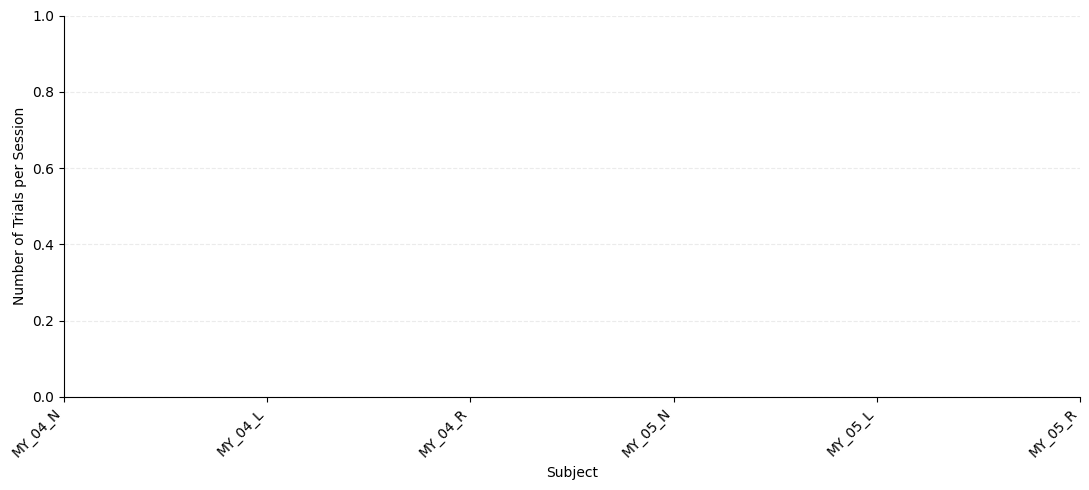

In [87]:
import numpy as np
import matplotlib.pyplot as plt

# assumes you already have: extract_trialwise() from your extract_trials.py
# and cohort1_data_by_problem / cohort2_data_by_problem are the same structure you used above.

def trials_in_session(session_dict: dict, *, drop_zero: bool = True) -> int:
    """
    Count trials in one session using extract_trialwise(df).
    If drop_zero=True, returns 0 but you can filter those out upstream.
    """
    df = session_dict["data"]
    trial_df = extract_trialwise(df)
    n = int(len(trial_df))
    return 0 if (drop_zero and n == 0) else n


def collect_trials_per_session(data_by_problem: dict, problem_key: str = "problem_1", *, drop_zero: bool = True):
    """
    data_by_problem format:
      { subject_id: { 'problem_1': [(session_key, session_dict), ...], ... }, ... }

    Returns:
      per_subject: {subject_id: [n_trials_session1, n_trials_session2, ...]}
    """
    per_subject = {}
    for subject_id, problems in data_by_problem.items():
        if problem_key not in problems:
            continue

        vals = []
        for _, session_dict in problems[problem_key]:
            n = trials_in_session(session_dict, drop_zero=False)
            if drop_zero and n == 0:
                continue
            vals.append(int(n))

        per_subject[subject_id] = vals

    return per_subject


import numpy as np
import matplotlib.pyplot as plt

def _get_color(subject_colors: dict, subj: str, default="gray"):
    if subject_colors is None:
        return default
    return subject_colors.get(subj, default)

def plot_trials_per_animal_with_session_dots(
    cohort1_data_by_problem: dict,
    cohort2_data_by_problem: dict,
    desired_order: list,
    problem_key: str = "problem_1",
    *,
    drop_zero_sessions: bool = True,
    title: str | None = "Trials per session (dots) + mean per animal (bar)",
    subject_colors: dict | None = None,
    bar_alpha: float = 0.35,
    dot_alpha: float = 0.90,
    jitter_width: float = 0.08,
    seed: int = 0,
):
    """
    Bar = mean #trials across sessions for each animal (colored by subject).
    Dots = each session’s #trials (colored by subject, jittered).
    """

    # Collect per-session trial counts
    c1 = collect_trials_per_session(cohort1_data_by_problem, problem_key, drop_zero=drop_zero_sessions)
    c2 = collect_trials_per_session(cohort2_data_by_problem, problem_key, drop_zero=drop_zero_sessions)
    per_subject = {**c1, **c2}

    # Compute means
    means = []
    for subj in desired_order:
        vals = per_subject.get(subj, [])
        means.append(np.mean(vals) if len(vals) else np.nan)

    x = np.arange(len(desired_order))
    fig, ax = plt.subplots(figsize=(11, 5))

    # Bars: draw individually so each subject gets its own color
    for i, subj in enumerate(desired_order):
        m = means[i]
        if np.isnan(m):
            continue
        ax.bar(
            x[i],
            m,
            color=_get_color(subject_colors, subj, default="gray"),
            edgecolor="black",
            alpha=bar_alpha,
            zorder=1,
        )

    # Dots per session (subject-colored)
    rng = np.random.default_rng(seed)
    for i, subj in enumerate(desired_order):
        vals = per_subject.get(subj, [])
        if not vals:
            continue
        jitter = rng.uniform(-jitter_width, jitter_width, size=len(vals))
        ax.scatter(
            np.full(len(vals), x[i]) + jitter,
            vals,
            s=35,
            color=_get_color(subject_colors, subj, default="gray"),
            edgecolors="black",
            linewidths=0.5,
            alpha=dot_alpha,
            zorder=3,
        )

    ax.set_xticks(x)
    ax.set_xticklabels(desired_order, rotation=45, ha="right")
    ax.set_ylabel("Number of Trials per Session")
    ax.set_xlabel("Subject")
    if title:
        ax.set_title(title)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(axis="y", alpha=0.25, linestyle="--", zorder=0)

    plt.tight_layout()
    return fig, ax

# =============================================================================
# Example usage
# =============================================================================

# desired_order should include the 2 cohort1 IDs + the 6 cohort2 IDs in the order you want
# desired_order = ["MY_...", ...]

fig, ax = plot_trials_per_animal_with_session_dots(
    cohort1_data_by_problem=cohort1_data_by_problem,
    cohort2_data_by_problem=cohort2_data_by_problem,
    desired_order=desired_order,
    problem_key="problem_1",
    drop_zero_sessions=True,
    title=None,
    subject_colors=subject_colors,   # <-- your consistent mapping
)
plt.show()


In [88]:
import json
import numpy as np

# ---- aliases actually seen in your files for rank_counts ----
RANK_COUNT_KEYS = {
    "best": ("best",),
    "second": ("second_best", "second"),   # old and new
    "third": ("third_best", "third"),      # old and new
}

# also support flattened df columns from normalized JSON
RANK_COUNT_COLS = {
    "best": ("rank_counts.best",),
    "second": ("rank_counts.second_best", "rank_counts.second"),
    "third": ("rank_counts.third_best", "rank_counts.third"),
}

def _safe_parse_json(x):
    if isinstance(x, dict):
        return x
    if x is None:
        return {}
    if isinstance(x, float) and np.isnan(x):
        return {}
    if isinstance(x, str):
        x = x.strip()
        if not x:
            return {}
        # many of your rows are JSON objects
        if x.startswith("{") and x.endswith("}"):
            try:
                return json.loads(x)
            except Exception:
                return {}
    return {}

def _get_first_present(d, keys, default=0):
    for k in keys:
        if k in d and d[k] is not None:
            return d[k]
    return default

def _get_first_present_col(row, cols, default=0):
    for c in cols:
        if c in row.index:
            v = row.get(c)
            if v is not None and not (isinstance(v, float) and np.isnan(v)):
                return v
    return default

def extract_rank_counts_from_run_end(df):
    """
    Returns (best, second, third) counts for one session df by reading run_end.

    Supports:
      1) content JSON with rank_counts dict using old/new keys
      2) flattened columns rank_counts.best / rank_counts.second_best / rank_counts.third_best
         and rank_counts.second / rank_counts.third
    """
    if not {"type", "subtype"}.issubset(df.columns):
        return 0, 0, 0

    run_end_rows = df[(df["type"] == "variable") & (df["subtype"] == "run_end")]
    if run_end_rows.empty:
        return 0, 0, 0

    row = run_end_rows.iloc[-1]

    # (A) Try flattened columns first (most reliable if present)
    best_col = _get_first_present_col(row, RANK_COUNT_COLS["best"], default=None)
    second_col = _get_first_present_col(row, RANK_COUNT_COLS["second"], default=None)
    third_col = _get_first_present_col(row, RANK_COUNT_COLS["third"], default=None)

    if best_col is not None or second_col is not None or third_col is not None:
        best = int(best_col or 0)
        second = int(second_col or 0)
        third = int(third_col or 0)
        return best, second, third

    # (B) Fall back to content JSON
    d = _safe_parse_json(row.get("content", ""))
    rank_counts = d.get("rank_counts", {})
    if not isinstance(rank_counts, dict):
        return 0, 0, 0

    best = int(_get_first_present(rank_counts, RANK_COUNT_KEYS["best"], 0) or 0)
    second = int(_get_first_present(rank_counts, RANK_COUNT_KEYS["second"], 0) or 0)
    third = int(_get_first_present(rank_counts, RANK_COUNT_KEYS["third"], 0) or 0)
    return best, second, third


# =============================================================================
# Compute choice proportions by arm rank for each subject and problem
# (robust to old/new rank_count keys + flattened cols)
# =============================================================================

cohort1_choice_proportions = {}

for problem_key in ["problem_1"]:
    cohort1_choice_proportions[problem_key] = {}

    for subject_id in desired_order:
        if subject_id not in cohort1_data_by_problem:
            continue

        problems = cohort1_data_by_problem[subject_id]
        if problem_key not in problems:
            continue

        total_best = 0
        total_second = 0
        total_third = 0

        for _, session_dict in problems[problem_key]:
            df = session_dict["data"]

            b, s, t = extract_rank_counts_from_run_end(df)
            total_best += b
            total_second += s
            total_third += t

        total = total_best + total_second + total_third
        if total > 0:
            cohort1_choice_proportions[problem_key][subject_id] = {
                "best": total_best / total,
                "second_best": total_second / total,   # keep your downstream naming stable
                "third_best": total_third / total,     # keep your downstream naming stable
                "n": total,
            }

print("Choice proportions computed for cohort 1 (run_end rank_counts, alias-safe)")
print(f"problem 1: {list(cohort1_choice_proportions['problem_1'].keys())}")

cohort2_choice_proportions = {}

for problem_key in ["problem_1"]:
    cohort2_choice_proportions[problem_key] = {}

    for subject_id in desired_order:
        if subject_id not in cohort2_data_by_problem:
            continue

        problems = cohort2_data_by_problem[subject_id]
        if problem_key not in problems:
            continue

        total_best = 0
        total_second = 0
        total_third = 0

        for _, session_dict in problems[problem_key]:
            df = session_dict["data"]
            b, s, t = extract_rank_counts_from_run_end(df)
            total_best += b
            total_second += s
            total_third += t

        total = total_best + total_second + total_third
        if total > 0:
            cohort2_choice_proportions[problem_key][subject_id] = {
                "best": total_best / total,
                "second_best": total_second / total,
                "third_best": total_third / total,
                "n": total,
            }

print("Choice proportions computed for cohort 2 (run_end rank_counts, alias-safe)")
print(f"problem 1: {list(cohort2_choice_proportions['problem_1'].keys())}")

Choice proportions computed for cohort 1 (run_end rank_counts, alias-safe)
problem 1: []
Choice proportions computed for cohort 2 (run_end rank_counts, alias-safe)
problem 1: []


In [89]:
import numpy as np
import matplotlib.pyplot as plt

def _subset_choice_props(choice_proportions, problem_key, desired_order):
    subjects = []
    best_props, second_props, third_props = [], [], []
    for sid in desired_order:
        if sid in choice_proportions.get(problem_key, {}):
            props = choice_proportions[problem_key][sid]
            subjects.append(sid)
            best_props.append(props["best"])
            second_props.append(props["second_best"])
            third_props.append(props["third_best"])
    return subjects, best_props, second_props, third_props

def plot_choice_proportions_for_one_cohort(
    choice_proportions: dict,
    *,
    cohort_name: str,
    desired_order: list,
    subject_colors: dict,
    problem_keys=("problem_1",),
    agg="mean",  # "median" or "mean"
):
    """
    Make your 'bars + subject lines' plot for ONE cohort.
    Call this twice (cohort1 then cohort2) to get two separate plots.
    """
    agg_fn = np.median if agg == "median" else np.mean

    for problem_key in problem_keys:
        problem_num = problem_key.split("_")[1]

        fig, ax = plt.subplots(figsize=(8, 6))

        subjects, best_props, second_props, third_props = _subset_choice_props(
            choice_proportions, problem_key, desired_order
        )

        # Background cohort aggregate bars
        if len(best_props):
            a_best = float(agg_fn(best_props))
            a_second = float(agg_fn(second_props))
            a_third = float(agg_fn(third_props))

            x_bar = [0, 1, 2]
            means = [a_best, a_second, a_third]
            bar_colors = ["#c8c8c8", "#d8d8d8", "#e8e8e8"]

            ax.bar(
                x_bar, means,
                color=bar_colors,
                edgecolor="black",
                linewidth=1.5,
                width=0.6,
                alpha=0.6,
                zorder=1,
            )

            # Labels on bars
            for x0, val in zip(x_bar, means):
                ax.text(
                    x0, 0.98, f"{val:.2f}",
                    ha="center", va="bottom",
                    fontsize=10, color="black",
                )

        # Subject lines
        for sid in subjects:
            props = choice_proportions[problem_key][sid]
            x = [0, 1, 2]
            y = [props["best"], props["second_best"], props["third_best"]]
            ax.plot(
                x, y, "o-",
                color=subject_colors.get(sid, "black"),
                linewidth=2,
                markersize=8,
                alpha=0.85,
                label=sid,
                zorder=3,
            )

        # Styling
        ax.set_xlim(-0.4, 2.4)
        ax.set_ylim(0, 1.05)
        ax.set_xticks([0, 1, 2])
        ax.set_xticklabels(["best", "second_best", "third_best"], fontsize=12)
        ax.set_ylabel("Proportion of Choices", fontsize=12)
        """
        ax.set_title(
            f"{cohort_name} — Problem {problem_num}: Choice Proportions by Arm Rank",
            fontsize=14, fontweight="bold",
        )
        """
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(axis="y", alpha=0.3, linestyle="--", zorder=2)
        ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=True)

        plt.tight_layout()
        plt.show()

/var/folders/g7/dhg2tq9173j2cwmlq6jvq28r0000gn/T/ipykernel_68832/2615857966.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=True)


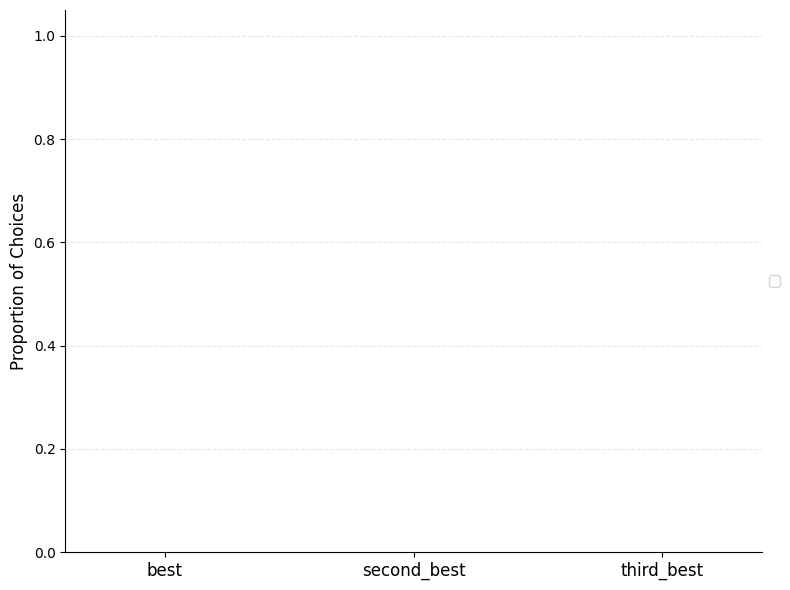

In [90]:
plot_choice_proportions_for_one_cohort(
    choice_proportions=cohort2_choice_proportions,
    cohort_name="Cohort 2",
    desired_order=desired_order,
    subject_colors=subject_colors,
    problem_keys=("problem_1",),
    agg="mean",
)


In [91]:
import numpy as np
import pandas as pd

# --- rank label aliases you actually see ---
RANK_LABEL_ALIASES = {
    "best": ("best",),
    "second_best": ("second_best", "second"),
    "third_best": ("third_best", "third"),
}

def _first_col(df: pd.DataFrame, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def _normalize_str_series(s: pd.Series) -> pd.Series:
    return s.astype("string").fillna("").str.strip().str.upper()

def _trial_rank_series(trial_df: pd.DataFrame) -> pd.Series:
    """
    Returns a Series of rank labels per trial: 'Best'/'Second'/'Third' or <NA>.
    Alias-safe for second/third.
    """
    choice = _normalize_str_series(trial_df["chosen_tower"])

    c_best   = _first_col(trial_df, RANK_LABEL_ALIASES["best"])
    c_second = _first_col(trial_df, RANK_LABEL_ALIASES["second_best"])
    c_third  = _first_col(trial_df, RANK_LABEL_ALIASES["third_best"])

    if c_best is None or c_second is None or c_third is None:
        # can't compute ranks
        return pd.Series([pd.NA] * len(trial_df), index=trial_df.index, dtype="string")

    best   = _normalize_str_series(trial_df[c_best])
    second = _normalize_str_series(trial_df[c_second])
    third  = _normalize_str_series(trial_df[c_third])

    out = pd.Series([pd.NA] * len(trial_df), index=trial_df.index, dtype="string")
    out.loc[choice == best] = "Best"
    out.loc[choice == second] = "Second"
    out.loc[choice == third] = "Third"
    return out

def compute_transition_matrices_by_problem(
    data_by_problem: dict,
    problem_key: str = "problem_1",
    *,
    drop_zero_sessions: bool = True,
):
    """
    data_by_problem format:
      { subject_id: { 'problem_1': [(session_key, session_dict), ...], ... }, ... }

    Returns:
      transition_mats = {
        problem_key: {
          subject_id: {
            'matrix': 3x3 probs,
            'counts': 3x3 counts,
            'ranks': ['Best','Second','Third']
          }, ...
        },
        f"{problem_key}__cohort_average": {
          'matrix': 3x3 probs,
          'counts': 3x3 counts,
          'ranks': ['Best','Second','Third']
        }
      }
    """
    rank_labels = ["Best", "Second", "Third"]
    rank_to_idx = {r: i for i, r in enumerate(rank_labels)}
    n = 3

    out = {problem_key: {}}
    cohort_counts = np.zeros((n, n), dtype=float)

    for subject_id, problems in data_by_problem.items():
        if problem_key not in problems:
            continue

        subj_counts = np.zeros((n, n), dtype=float)

        for _, session_dict in problems[problem_key]:
            df = session_dict["data"]

            # extract trials
            trial_df = extract_trialwise(df)
            if drop_zero_sessions and len(trial_df) == 0:
                continue
            if len(trial_df) < 2:
                continue

            # ensure rank columns exist
            trial_df = add_rank_and_equality_cols(trial_df)

            ranks = _trial_rank_series(trial_df)
            ranks = ranks.dropna()
            if len(ranks) < 2:
                continue

            # transitions within THIS session only
            r0 = ranks.iloc[:-1].to_numpy()
            r1 = ranks.iloc[1:].to_numpy()

            for a, b in zip(r0, r1):
                i = rank_to_idx.get(a, None)
                j = rank_to_idx.get(b, None)
                if i is not None and j is not None:
                    subj_counts[i, j] += 1

        # convert to probs
        probs = subj_counts.copy()
        row_sums = probs.sum(axis=1, keepdims=True)
        probs = np.divide(probs, row_sums, where=row_sums != 0, out=np.zeros_like(probs))

        out[problem_key][subject_id] = {
            "matrix": probs,
            "counts": subj_counts,
            "ranks": rank_labels,
            "rank_to_idx": rank_to_idx,
        }

        cohort_counts += subj_counts

    # cohort average (counts summed first, then row-normalized)
    cohort_probs = cohort_counts.copy()
    row_sums = cohort_probs.sum(axis=1, keepdims=True)
    cohort_probs = np.divide(cohort_probs, row_sums, where=row_sums != 0, out=np.zeros_like(cohort_probs))

    out[f"{problem_key}__cohort_average"] = {
        "matrix": cohort_probs,
        "counts": cohort_counts,
        "ranks": rank_labels,
        "rank_to_idx": rank_to_idx,
    }

    return out

In [92]:
cohort1_transition = compute_transition_matrices_by_problem(
    cohort1_data_by_problem,
    problem_key="problem_1",
    drop_zero_sessions=True,
)

cohort2_transition = compute_transition_matrices_by_problem(
    cohort2_data_by_problem,
    problem_key="problem_1",
    drop_zero_sessions=True,
)

# sanity check keys
print("Cohort 1 subjects:", list(cohort1_transition["problem_1"].keys()))
print("Cohort 2 subjects:", list(cohort2_transition["problem_1"].keys()))

Cohort 1 subjects: ['MY_300_N', 'MY_299_N']
Cohort 2 subjects: []


In [93]:
def plot_subject_transition_matrices(
    transition_obj: dict,
    desired_order: list,
    problem_key: str = "problem_1",
    *,
    title_prefix: str = "",
):
    mats = transition_obj.get(problem_key, {})
    problem_num = problem_key.split("_")[1]

    n_subjects = len(desired_order)
    n_cols = 4
    n_rows = (n_subjects + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
    axes = np.array(axes).reshape(-1)

    for idx, subject_id in enumerate(desired_order):
        ax = axes[idx]

        if subject_id in mats:
            data = mats[subject_id]
            matrix = data["matrix"]
            ranks = data["ranks"]

            im = ax.imshow(matrix, cmap="Blues", vmin=0, vmax=1, aspect="auto")

            for i in range(len(ranks)):
                for j in range(len(ranks)):
                    ax.text(j, i, f"{matrix[i, j]:.2f}", ha="center", va="center", color="black", fontsize=9)

            ax.set_xticks(range(len(ranks)))
            ax.set_yticks(range(len(ranks)))
            ax.set_xticklabels(ranks, fontsize=10)
            ax.set_yticklabels(ranks, fontsize=10)
            ax.set_xlabel("Next choice", fontsize=10)
            ax.set_ylabel("Current choice", fontsize=10)
            ax.set_title(subject_id, fontweight="bold", fontsize=11)
        else:
            ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes, fontsize=12, color="gray")
            ax.set_xticks([])
            ax.set_yticks([])

    for idx in range(n_subjects, len(axes)):
        axes[idx].axis("off")

    fig.suptitle(
        f"{title_prefix}Problem {problem_num}: Transition Matrices by Subject",
        fontsize=14,
        fontweight="bold",
        y=0.995,
    )
    plt.tight_layout()
    plt.show()

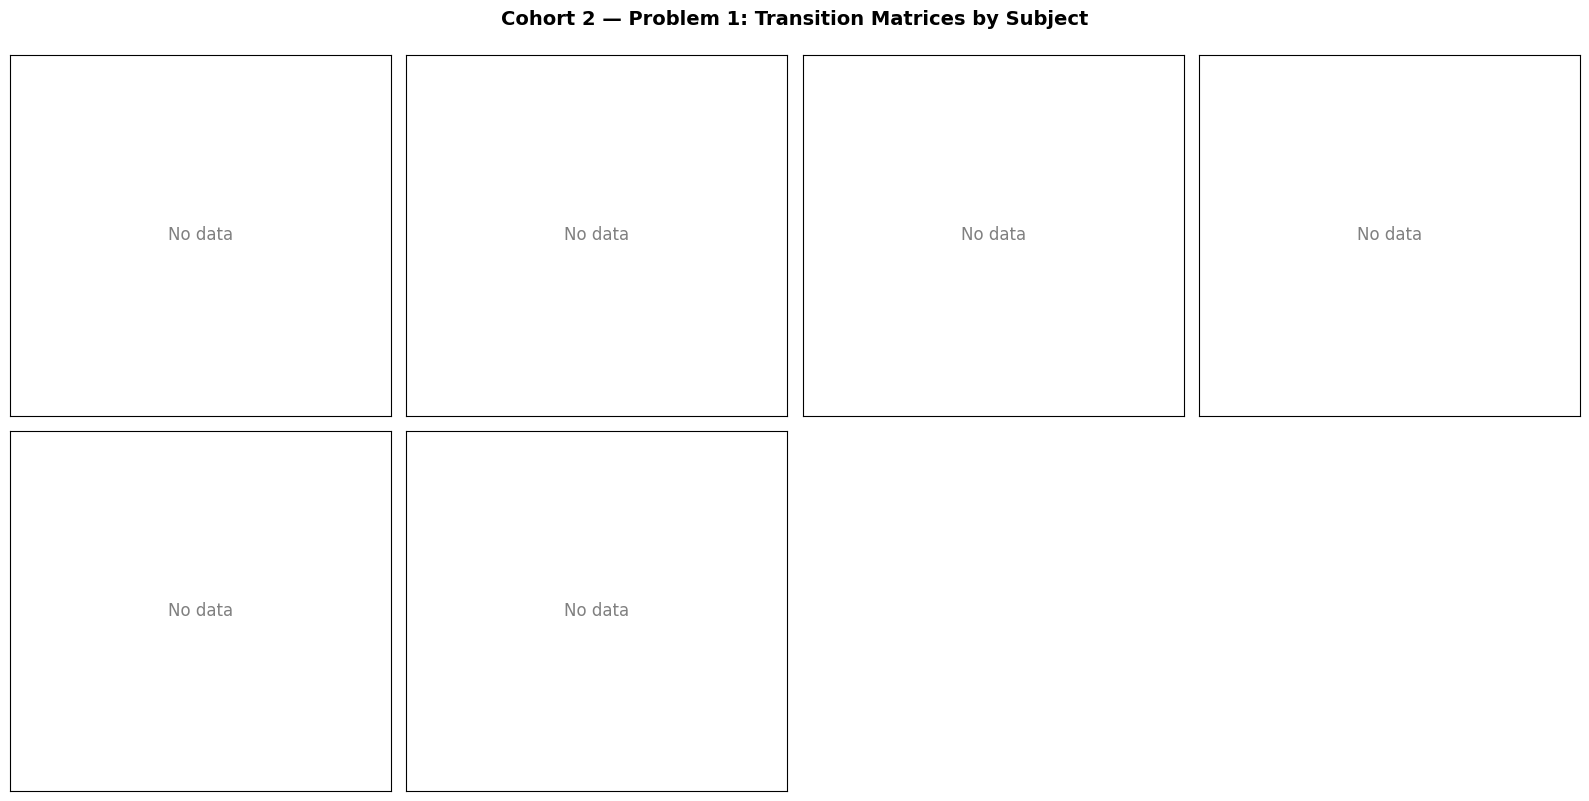

In [94]:
plot_subject_transition_matrices(
    cohort2_transition,
    desired_order,
    problem_key="problem_1",
    title_prefix="Cohort 2 — ",
)

In [95]:
def plot_cohort_average_transition(transition_obj: dict, problem_key="problem_1", title="Cohort average"):
    avg_key = f"{problem_key}__cohort_average"
    data = transition_obj[avg_key]
    matrix = data["matrix"]
    ranks = data["ranks"]

    fig, ax = plt.subplots(figsize=(4.8, 4.2))
    im = ax.imshow(matrix, cmap="Blues", vmin=0, vmax=1, aspect="auto")

    for i in range(len(ranks)):
        for j in range(len(ranks)):
            ax.text(j, i, f"{matrix[i, j]:.2f}", ha="center", va="center", color="black", fontsize=10)

    ax.set_xticks(range(len(ranks)))
    ax.set_yticks(range(len(ranks)))
    ax.set_xticklabels(ranks, fontsize=11)
    ax.set_yticklabels(ranks, fontsize=11)
    ax.set_xlabel("Next choice", fontsize=11)
    ax.set_ylabel("Current choice", fontsize=11)
    ax.set_title(title, fontweight="bold", fontsize=12)

    plt.tight_layout()
    plt.show()
    return fig, ax

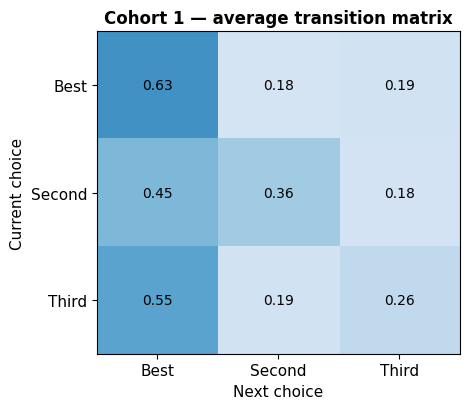

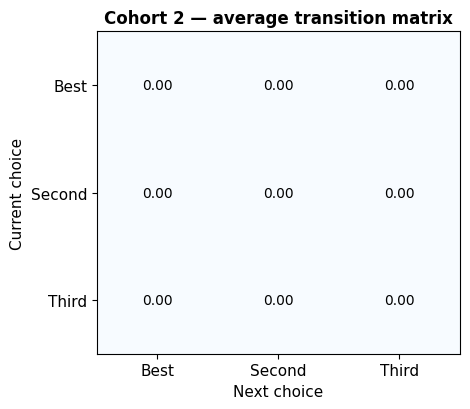

(<Figure size 480x420 with 1 Axes>,
 <Axes: title={'center': 'Cohort 2 — average transition matrix'}, xlabel='Next choice', ylabel='Current choice'>)

In [96]:
plot_cohort_average_transition(cohort1_transition, "problem_1", title="Cohort 1 — average transition matrix")
plot_cohort_average_transition(cohort2_transition, "problem_1", title="Cohort 2 — average transition matrix")

In [97]:
LONG_POKE_COLS = ("num_long_pokes_before_choice", "num_long_pokes")

def _first_present_col(df: pd.DataFrame, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def _session_id_from_key(session_key: str) -> str:
    """
    Convert 'ses-01_2026-01-11' -> 'ses-01'
    If it's already 'ses-01', returns it unchanged.
    """
    s = str(session_key)
    return s.split("_", 1)[0]

def mean_long_pokes_in_session(session_dict: dict, *, drop_zero_trials: bool = True) -> float:
    """
    Returns mean long pokes per trial for one session.
    Uses extract_trialwise(df) so you're working trialwise.
    Alias-safe for long poke variable names.
    """
    df = session_dict["data"]
    trial_df = extract_trialwise(df)

    # if there are 0 trials, return NaN (so it can be dropped/ignored in plots)
    if len(trial_df) == 0:
        return np.nan if drop_zero_trials else 0.0

    col = _first_present_col(trial_df, LONG_POKE_COLS)
    if col is None:
        # no long poke info in trialwise output
        return np.nan

    vals = pd.to_numeric(trial_df[col], errors="coerce")
    if vals.notna().sum() == 0:
        return np.nan

    return float(vals.mean())

def collect_long_poke_means_by_session(
    data_by_problem: dict,
    problem_key: str = "problem_1",
    *,
    drop_zero_trials: bool = True,
):
    """
    Returns:
      session_ids_sorted: ['ses-01','ses-02',...]
      per_subject: {subject_id: {session_id: mean_long_pokes}}
    """
    per_subject = {}
    all_session_ids = set()

    for subject_id, problems in data_by_problem.items():
        if problem_key not in problems:
            continue

        subj_map = {}
        for session_key, session_dict in problems[problem_key]:
            ses_id = _session_id_from_key(session_key)
            m = mean_long_pokes_in_session(session_dict, drop_zero_trials=drop_zero_trials)

            # keep NaNs too (we'll ignore in aggregation/plotting)
            subj_map[ses_id] = m
            if not np.isnan(m):
                all_session_ids.add(ses_id)

        per_subject[subject_id] = subj_map

    # Sort session ids numerically by the two-digit part if present
    def _ses_sort_key(s):
        try:
            return int(str(s).replace("ses-", ""))
        except Exception:
            return str(s)

    session_ids_sorted = sorted(all_session_ids, key=_ses_sort_key)
    return session_ids_sorted, per_subject

In [98]:
def plot_long_pokes_by_session(
    *,
    data_by_problem: dict,
    cohort_name: str,
    desired_order: list,
    subject_colors: dict,
    problem_key: str = "problem_1",
    agg: str = "mean",   # "mean" or "median"
    drop_zero_trials: bool = True,
):
    """
    X-axis: session_id (ses-01, ses-02, ...)
    Y-axis: mean long pokes per trial in that session (per subject)
    Background bars: cohort aggregate at each session_id
    Subject lines: per-subject values across sessions (same colors as other plots)
    """
    agg_fn = np.nanmedian if agg == "median" else np.nanmean

    session_ids, per_subject = collect_long_poke_means_by_session(
        data_by_problem,
        problem_key=problem_key,
        drop_zero_trials=drop_zero_trials,
    )

    if not session_ids:
        print(f"[{cohort_name}] No sessions with usable long poke data in {problem_key}.")
        return None, None

    # Build cohort aggregate per session (across subjects)
    cohort_vals = []
    for ses in session_ids:
        vals = []
        for sid in desired_order:
            v = per_subject.get(sid, {}).get(ses, np.nan)
            vals.append(v)
        cohort_vals.append(float(agg_fn(vals)) if np.any(~np.isnan(vals)) else np.nan)

    x = np.arange(len(session_ids))

    fig, ax = plt.subplots(figsize=(10, 5))

    # Background bars
    ax.bar(
        x, cohort_vals,
        color="#d8d8d8",
        edgecolor="black",
        linewidth=1.2,
        width=0.65,
        alpha=0.6,
        zorder=1,
    )

    # Labels on bars (fixed y-position + larger font)
    for x0, val in zip(x, cohort_vals):
        if np.isnan(val):
            continue
        ax.text(
            x0,
            7.0,                 # <- fixed y position
            f"{val:.2f}",
            ha="center",
            va="bottom",
            fontsize=14,         # <- larger font
            color="black",
            zorder=4,
        )

    # Subject lines
    for sid in desired_order:
        subj_map = per_subject.get(sid, {})
        y = np.array([subj_map.get(ses, np.nan) for ses in session_ids], dtype=float)

        if np.all(np.isnan(y)):
            continue

        ax.plot(
            x, y, "o-",
            color=subject_colors.get(sid, "black"),
            linewidth=2,
            markersize=7,
            alpha=0.85,
            label=sid,
            zorder=3,
        )

    ax.set_xticks(x)
    ax.set_xticklabels(session_ids, rotation=45, ha="right", fontsize=11)
    ax.set_ylabel("Mean Pokes Before Choice", fontsize=12)
    ax.set_xlabel("Session", fontsize=12)
    ax.set_ylim(0, 7.05)

    # If you want a title, uncomment:
    # ax.set_title(f"{cohort_name} — {problem_key}: Long pokes by session", fontsize=14, fontweight="bold")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(axis="y", alpha=0.3, linestyle="--", zorder=2)
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=True)

    plt.tight_layout()
    plt.show()
    return fig, ax

In [99]:
fig, ax = plot_long_pokes_by_session(
    data_by_problem=cohort2_data_by_problem,
    cohort_name="Cohort 2",
    desired_order=desired_order,
    subject_colors=subject_colors,
    problem_key="problem_1",
    agg="mean",
    drop_zero_trials=True,
)

[Cohort 2] No sessions with usable long poke data in problem_1.


In [100]:
# =========================
# FULL NOTEBOOK CELL: Maze-style heatmaps (problem-based) with:
# - After initiation (wait_for_choice_poke / wait_choice): EVENT-BASED
# - After choice (wait_for_initiation_poke / wait_init): EVENT-BASED + cap initial run of CHOSEN tower
# - Highlights: GREEN = current problem towers, RED (inset/thinner) = previous problem towers (optional)
# - Per-subject normalization (0 -> subject max), shared conceptual colorbar (0, max), label rotated 270
# =========================

import ast
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
from matplotlib.patches import RegularPolygon
from typing import Dict, List, Tuple, Optional

ARMS9 = ["A1","A2","A3","B1","B2","B3","C1","C2","C3"]

# ------------------------------------------------------
# Robust print-line parsing (JSON or python-literal dict)
# ------------------------------------------------------
def _parse_print_dict(s: str):
    if not isinstance(s, str):
        return None
    s = s.strip()
    if not s:
        return None
    try:
        return json.loads(s)
    except Exception:
        pass
    try:
        return ast.literal_eval(s)
    except Exception:
        return None

def _extract_chosen_tower_from_slice(slc: pd.DataFrame) -> Optional[str]:
    if "subtype" not in slc.columns or "content" not in slc.columns:
        return None
    chosen = None
    for x in slc.loc[slc["subtype"] == "print", "content"]:
        d = _parse_print_dict(x)
        if isinstance(d, dict) and "chosen_tower" in d:
            chosen = d.get("chosen_tower")
            break
    if isinstance(chosen, str):
        chosen = chosen.strip().upper()
    return chosen if chosen in ARMS9 else None

def _extract_pokes_from_slice(slc: pd.DataFrame) -> List[str]:
    # expects slc["content"] with events like "A1_in"
    mask = slc["content"].astype(str).str.contains(r"\b[ABC][123]_in\b", regex=True, na=False)
    series = slc.loc[mask, "content"].astype(str).str.extract(r"\b([ABC][123])_in\b", expand=False).dropna()
    return series.tolist()

# ------------------------------------------------------
# AFTER INITIATION (wait_for_choice_poke / wait_choice)
# Event-based occupancy + optionally add chosen tower
# ------------------------------------------------------
def get_pokes_after_initiation_eventbased(
    df: pd.DataFrame,
    *,
    states: Tuple[str, ...] = ("wait_for_choice_poke", "wait_choice"),
    initiation_tower: str = "B2",
    include_initiation_tower: bool = False,
    include_choice_as_poke: bool = True,
) -> Tuple[Dict[str, int], Dict[int, List[str]]]:
    counter = {k: 0 for k in ARMS9}
    pokes_across_trials: Dict[int, List[str]] = {}

    state_df = df[df["content"].isin(states)]
    idx = state_df.index.to_list()
    pairs = list(zip(idx, idx[1:]))
    slices = [df.loc[start:end] for start, end in pairs]

    trial_number = 1
    for slc in slices:
        towers = _extract_pokes_from_slice(slc)

        if not include_initiation_tower and initiation_tower:
            towers = [t for t in towers if t != initiation_tower]

        if include_choice_as_poke:
            chosen = _extract_chosen_tower_from_slice(slc)
            if chosen and (include_initiation_tower or chosen != initiation_tower) and chosen not in towers:
                towers.append(chosen)

        for t in towers:
            counter[t] += 1

        pokes_across_trials[trial_number] = towers
        trial_number += 1

    return counter, pokes_across_trials

# ------------------------------------------------------
# AFTER CHOICE (wait_for_initiation_poke / wait_init)
# Event-based occupancy + CAP initial run of CHOSEN tower
# ------------------------------------------------------
def get_pokes_after_choice_eventbased(
    df: pd.DataFrame,
    *,
    states: Tuple[str, ...] = ("wait_for_initiation_poke", "wait_init"),
    cap_choice_before_other: int = 2,   # example: C3 C3 C3 B1 ... -> count C3 twice from the initial run
) -> Tuple[Dict[str, int], Dict[int, List[str]]]:
    counter = {k: 0 for k in ARMS9}
    pokes_across_trials: Dict[int, List[str]] = {}

    state_df = df[df["content"].isin(states)]
    idx = state_df.index.to_list()
    pairs = list(zip(idx, idx[1:]))
    slices = [df.loc[start:end] for start, end in pairs]

    trial_number = 1
    for slc in slices:
        chosen = _extract_chosen_tower_from_slice(slc)  # chosen for THIS trial
        pokes = _extract_pokes_from_slice(slc)

        # cap initial run of chosen tower before first different tower
        if chosen and cap_choice_before_other is not None:
            run_len = 0
            for p in pokes:
                if p == chosen:
                    run_len += 1
                else:
                    break
            if run_len > cap_choice_before_other:
                pokes = pokes[:cap_choice_before_other] + pokes[run_len:]

        for p in pokes:
            counter[p] += 1

        pokes_across_trials[trial_number] = pokes
        trial_number += 1

    return counter, pokes_across_trials

# ------------------------------------------------------
# Pick the correct event log df from a session dict
# Must contain 'content' and 'subtype'
# ------------------------------------------------------
def _get_event_df(sess: dict, candidates=("events", "event_df", "raw", "log", "data", "df")) -> Optional[pd.DataFrame]:
    for k in candidates:
        v = sess.get(k, None)
        if isinstance(v, pd.DataFrame) and {"content", "subtype"}.issubset(v.columns):
            return v
    for v in sess.values():
        if isinstance(v, pd.DataFrame) and {"content", "subtype"}.issubset(v.columns):
            return v
    return None

# ------------------------------------------------------
# Accumulate across sessions (problem-level)
# ------------------------------------------------------
def accumulate_pokes_over_sessions(
    session_dicts: List[dict],
    *,
    phase: str,  # "after_initiation" | "after_choice"
    initiation_tower: str,
    cap_choice_before_other: int = 2,
):
    total_counter = {k: 0 for k in ARMS9}
    all_trials: Dict[int, List[str]] = {}
    trial_offset = 0

    for sess in session_dicts:
        event_df = _get_event_df(sess)
        if event_df is None:
            continue

        if phase == "after_initiation":
            counter, trials = get_pokes_after_initiation_eventbased(
                event_df,
                states=("wait_for_choice_poke", "wait_choice"),
                initiation_tower=initiation_tower,
                include_initiation_tower=False,
                include_choice_as_poke=True,
            )
        elif phase == "after_choice":
            counter, trials = get_pokes_after_choice_eventbased(
                event_df,
                states=("wait_for_initiation_poke", "wait_init"),
                cap_choice_before_other=cap_choice_before_other,
            )
        else:
            raise ValueError("phase must be 'after_initiation' or 'after_choice'")

        for k in ARMS9:
            total_counter[k] += int(counter.get(k, 0))

        if trials:
            max_t = max(trials.keys())
            for t, v in trials.items():
                all_trials[trial_offset + int(t)] = v
            trial_offset += int(max_t)

    return total_counter, all_trials

# ------------------------------------------------------
# Build counters + tower info for a single problem key
# data_by_problem[subject][problem_key] = list of (session_id, session_dict)
# session_dict has: 'initiation_tower', 'choice_towers', and an event df somewhere
# ------------------------------------------------------
def build_problem_counters_and_tower_info(
    data_by_problem: dict,
    problem_key,
    desired_order: list,
    *,
    cap_choice_before_other: int = 2,
):
    after_choice_by_subject = {}
    after_initiation_by_subject = {}
    problem_tower_info = {}

    for sid in desired_order:
        if sid not in data_by_problem:
            continue
        if problem_key not in data_by_problem[sid]:
            continue

        sessions_list = data_by_problem[sid][problem_key]
        if not sessions_list:
            continue

        _, first_sess = sessions_list[0]
        initiation_tower = first_sess.get("initiation_tower", "")
        choice_towers = first_sess.get("choice_towers", [])

        session_dicts = [sess_dict for _, sess_dict in sessions_list]

        c_after_choice, _ = accumulate_pokes_over_sessions(
            session_dicts,
            phase="after_choice",
            initiation_tower=initiation_tower,
            cap_choice_before_other=cap_choice_before_other,
        )
        c_after_initiation, _ = accumulate_pokes_over_sessions(
            session_dicts,
            phase="after_initiation",
            initiation_tower=initiation_tower,
            cap_choice_before_other=cap_choice_before_other,
        )

        after_choice_by_subject[sid] = c_after_choice
        after_initiation_by_subject[sid] = c_after_initiation
        problem_tower_info[sid] = (initiation_tower, choice_towers)

    return after_choice_by_subject, after_initiation_by_subject, problem_tower_info

# ------------------------------------------------------
# Maze plotting
# ------------------------------------------------------
def plot_maze_heatmap_on_ax(
    ax,
    counter: dict,
    subject_id: str,
    *,
    initiation_tower: Optional[str] = None,
    choice_towers: Optional[List[str]] = None,
    highlight_initiation: bool = True,
    highlight_choices: bool = True,
    cmap: str = "Blues",
    vmin: float = 0,
    vmax: float = 1,
    highlight_color: str = "green",
    highlight_lw: float = 4.0,
    radius_scale: float = 1.0,
    draw_base: bool = True,
):
    well_map = {
        'A1': (0,0),'B1': (0,1),'C1': (0,2),
        'A2': (1,0),'B2': (1,1),'C2': (1,2),
        'A3': (2,0),'B3': (2,1),'C3': (2,2)
    }

    G = nx.grid_2d_graph(3,3)
    pos = {(x,y):(0.65*y,0.65*(2-x)) for x,y in G.nodes()}

    if draw_base:
        for u,v in G.edges():
            ax.plot(*zip(pos[u],pos[v]), lw=20, color="#c9d2d7", zorder=1)

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap_obj = mpl.cm.get_cmap(cmap)

    def draw_node(label, face, edge="black", lw=2.0, rscale=1.0, z=2, text=True):
        r,c = well_map[label]
        x,y = pos[(r,c)]
        poly = RegularPolygon(
            (x, y),
            numVertices=8,
            radius=0.18 * rscale,
            orientation=np.pi / 8,
            facecolor=face,
            edgecolor=edge,
            linewidth=lw,
            zorder=z
        )
        ax.add_patch(poly)
        if text:
            ax.text(x, y, label, ha="center", va="center", fontsize=11, weight="bold", zorder=3)

    if draw_base:
        for a in ARMS9:
            draw_node(a, cmap_obj(norm(int(counter.get(a,0)))))

    def highlight(a):
        draw_node(a, (0,0,0,0), edge=highlight_color, lw=highlight_lw, rscale=radius_scale, z=6, text=False)

    if highlight_initiation and initiation_tower:
        highlight(initiation_tower)
    if highlight_choices and choice_towers:
        for t in choice_towers:
            highlight(t)

    if draw_base:
        ax.set_title(subject_id, fontsize=16, weight="bold")
        ax.axis("off")
        ax.set_aspect("equal")

def plot_multi_subject_problem_heatmaps(
    poke_data_by_subject: dict,
    title: str,
    phase: str,  # "after_choice" or "after_initiation"
    problem_tower_info: dict,
    *,
    desired_order: list,
    prev_problem_tower_info: Optional[dict] = None,
    cmap: str = "Blues",
):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8), constrained_layout=True)
    axes = axes.flatten()

    for ax, sid in zip(axes, desired_order):
        counter = poke_data_by_subject.get(sid)
        if not counter:
            ax.axis("off")
            ax.set_title(sid, fontsize=16, weight="bold")
            continue

        init, choices = problem_tower_info[sid]
        vmax = max([int(counter.get(k,0)) for k in ARMS9] or [1])
        if vmax == 0:
            vmax = 1

        # base
        plot_maze_heatmap_on_ax(ax, counter, sid, vmax=vmax, draw_base=True, cmap=cmap)

        # old problem in RED (inset & thinner)
        if prev_problem_tower_info and sid in prev_problem_tower_info:
            oinit, ochoices = prev_problem_tower_info[sid]
            plot_maze_heatmap_on_ax(
                ax, counter, sid,
                initiation_tower=oinit if phase=="after_choice" else None,
                choice_towers= ochoices if phase=="after_initiation" else None,
                highlight_color="crimson",
                highlight_lw=2.5,
                radius_scale=0.90,
                vmax=vmax,
                draw_base=False,
                cmap=cmap
            )

        # current problem in GREEN
        plot_maze_heatmap_on_ax(
            ax, counter, sid,
            initiation_tower=init if phase=="after_choice" else None,
            choice_towers= choices if phase=="after_initiation" else None,
            highlight_color="green",
            highlight_lw=4.0,
            radius_scale=1.00,
            vmax=vmax,
            draw_base=False,
            cmap=cmap
        )

    sm = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 1), cmap=mpl.cm.get_cmap(cmap))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes, fraction=0.02, pad=0.01)
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(["0", "max"])
    cbar.set_label("Poke Count", rotation=270, labelpad=12, fontsize=16)

    fig.suptitle(title, fontsize=18, weight="bold")
    return fig

# ------------------------------------------------------
# USAGE for a single-problem dataset cohort2_data_by_problem
# ------------------------------------------------------
# Find the only problem key
sid0 = next(sid for sid in desired_order if sid in cohort2_data_by_problem)
problem_key = next(iter(cohort2_data_by_problem[sid0].keys()))
print("Using problem:", problem_key)

# Build counters
after_choice_by_subject, after_initiation_by_subject, problem_tower_info = build_problem_counters_and_tower_info(
    cohort2_data_by_problem,
    problem_key=problem_key,
    desired_order=desired_order,
    cap_choice_before_other=2,   # <-- your requested behavior for after-choice
)

# Plot after choice
figA = plot_multi_subject_problem_heatmaps(
    after_choice_by_subject,
    title=f"{problem_key} — Pokes After Choice",
    phase="after_choice",
    problem_tower_info=problem_tower_info,
    desired_order=desired_order,
    prev_problem_tower_info=None,
)
plt.show()

# Plot after initiation
figB = plot_multi_subject_problem_heatmaps(
    after_initiation_by_subject,
    title=f"{problem_key} — Pokes After Initiation",
    phase="after_initiation",
    problem_tower_info=problem_tower_info,
    desired_order=desired_order,
    prev_problem_tower_info=None,
)
plt.show()


StopIteration: 

Using problem: problem_1


/var/folders/g7/dhg2tq9173j2cwmlq6jvq28r0000gn/T/ipykernel_68832/644026081.py:283: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_obj = mpl.cm.get_cmap(cmap)
/var/folders/g7/dhg2tq9173j2cwmlq6jvq28r0000gn/T/ipykernel_68832/644026081.py:362: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  sm = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 1), cmap=mpl.cm.get_cmap(cmap))


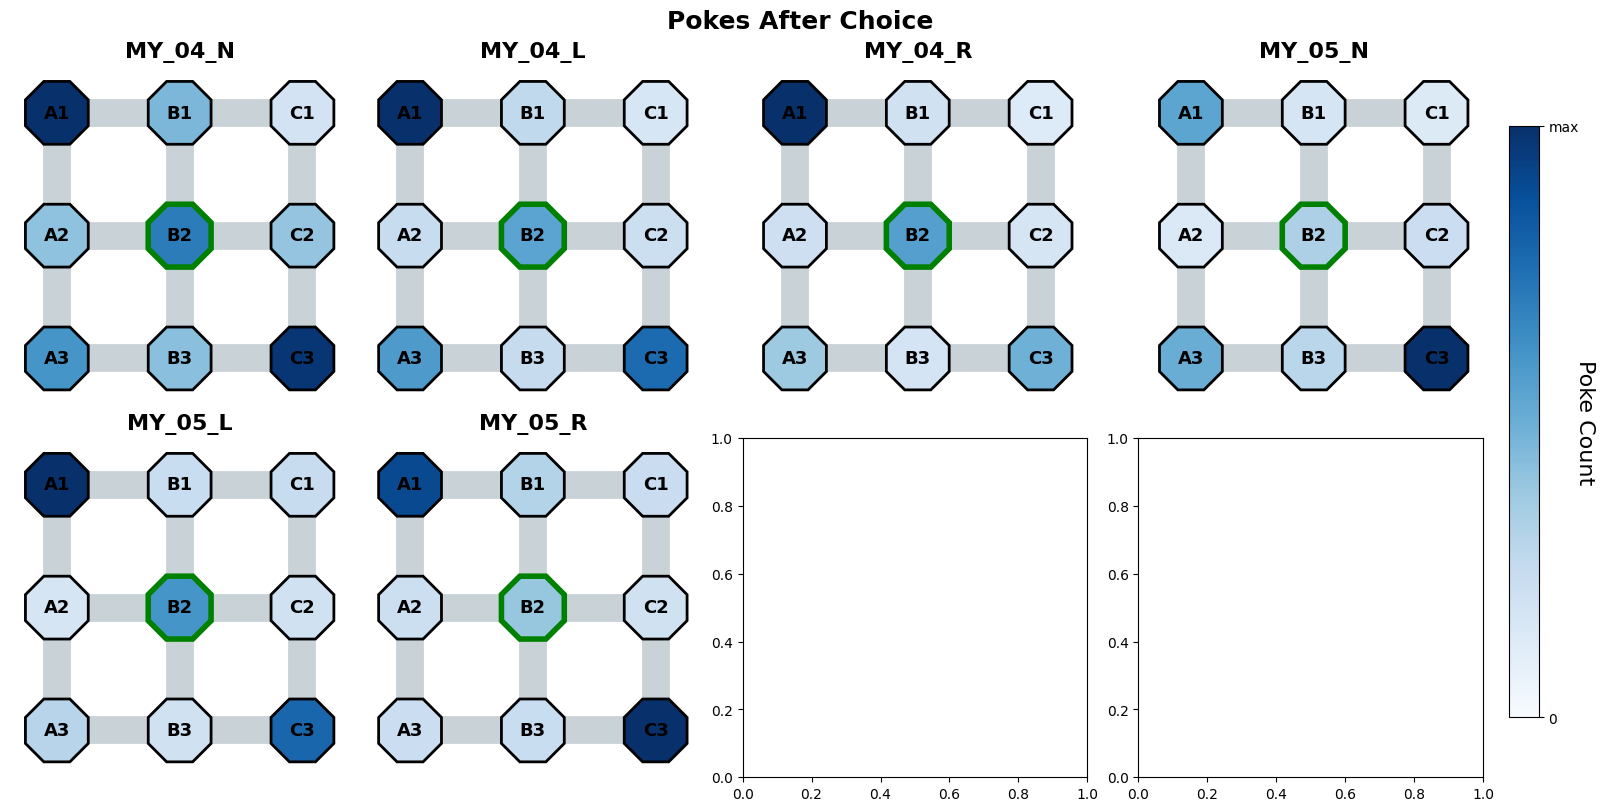

/var/folders/g7/dhg2tq9173j2cwmlq6jvq28r0000gn/T/ipykernel_68832/644026081.py:283: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_obj = mpl.cm.get_cmap(cmap)
/var/folders/g7/dhg2tq9173j2cwmlq6jvq28r0000gn/T/ipykernel_68832/644026081.py:362: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  sm = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 1), cmap=mpl.cm.get_cmap(cmap))


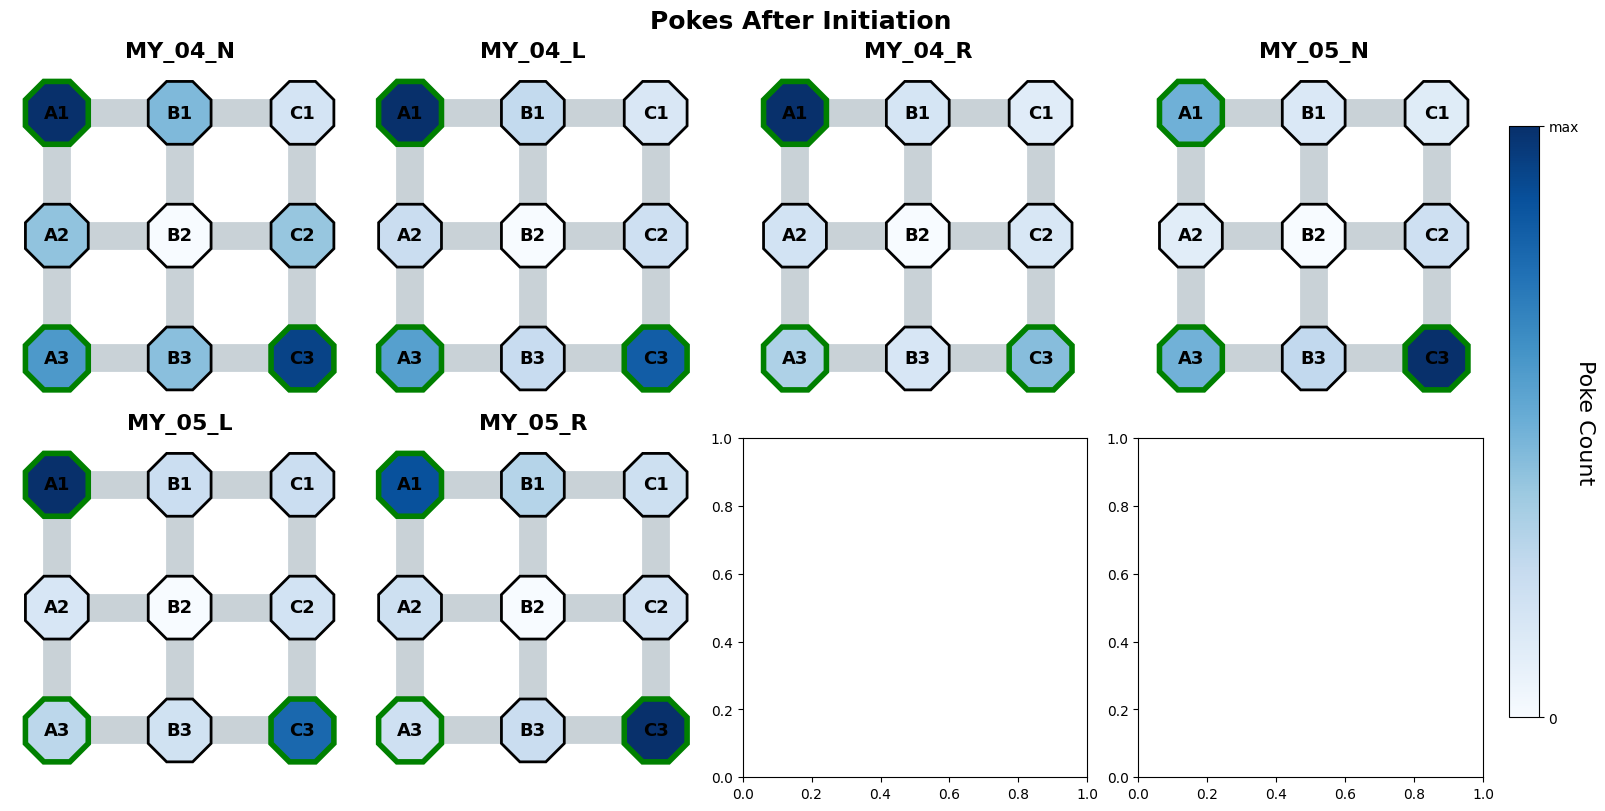

In [ ]:
# =========================
# FULL CELL: event-based counting (old style) + polygon maze heatmaps
# =========================

from typing import List, Dict, Tuple, Callable, Optional
import json, ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
from matplotlib.patches import RegularPolygon

ARMS9 = ["A1","A2","A3","B1","B2","B3","C1","C2","C3"]

# ------------------------------------------------------
# Robust parsing for print lines: JSON or python dict string
# ------------------------------------------------------
def _parse_print_dict(s: str):
    if not isinstance(s, str):
        return None
    s = s.strip()
    if not s:
        return None
    try:
        return json.loads(s)
    except Exception:
        pass
    try:
        return ast.literal_eval(s)
    except Exception:
        return None

def _extract_chosen_tower_from_slice(slc: pd.DataFrame) -> Optional[str]:
    if not {"subtype", "content"}.issubset(slc.columns):
        return None
    chosen = None
    for x in slc.loc[slc["subtype"] == "print", "content"]:
        d = _parse_print_dict(x)
        if isinstance(d, dict) and "chosen_tower" in d:
            chosen = d.get("chosen_tower")
            break
    if isinstance(chosen, str):
        chosen = chosen.strip().upper()
    return chosen if chosen in ARMS9 else None

# ------------------------------------------------------
# Counting: accumulate over sessions (event dfs)
# ------------------------------------------------------
def accumulate_pokes_over_sessions(
    session_event_dfs: List[pd.DataFrame],
    which: str = "during_initiation_wait",  # or "during_choice_wait"
    **kwargs
) -> Tuple[Dict[str, int], Dict[int, List[str]]]:

    if which == "during_initiation_wait":
        fp_fn: Callable = get_pokes_during_initiation_state
    elif which == "during_choice_wait":
        fp_fn: Callable = get_pokes_during_choice_state
    else:
        raise ValueError("which must be 'during_initiation_wait' or 'during_choice_wait'")

    cumulative_counter = {k: 0 for k in ARMS9}
    overall_pokes: Dict[int, List[str]] = {}
    overall_offset = 0

    for sess_df in session_event_dfs:
        counter, pokes_across_trials = fp_fn(sess_df, **kwargs)

        for k, v in counter.items():
            cumulative_counter[k] += int(v)

        if pokes_across_trials:
            session_len = max(pokes_across_trials.keys())
            for t, pokes in pokes_across_trials.items():
                overall_pokes[overall_offset + int(t)] = pokes
            overall_offset += session_len

    return cumulative_counter, overall_pokes

# ------------------------------------------------------
# AFTER INITIATION: wait_for_choice_poke OR wait_choice
# ------------------------------------------------------
def get_pokes_during_initiation_state(
    df: pd.DataFrame,
    state_aliases: Tuple[str, ...] = ("wait_for_choice_poke", "wait_choice"),
    initiation_tower: str = "B2",
    include_initiation_tower: bool = False,
    include_choice_as_poke: bool = True,
) -> Tuple[Dict[str, int], Dict[int, List[str]]]:

    counter = {k: 0 for k in ARMS9}

    state_df = df[df["content"].isin(state_aliases)]
    idx = state_df.index.to_list()
    pairs = list(zip(idx, idx[1:]))
    slices = [df.loc[start:end] for start, end in pairs]

    pokes_across_trials: Dict[int, List[str]] = {}
    trial_number = 1

    for slc in slices:
        mask = slc["content"].astype(str).str.contains(r"\b[ABC][123]_in\b", regex=True, na=False)
        series = slc.loc[mask, "content"].astype(str).str.extract(r"\b([ABC][123])_in\b", expand=False).dropna()
        pokes_list = series.tolist()

        if not include_initiation_tower and initiation_tower:
            pokes_list = [p for p in pokes_list if p != initiation_tower]

        if include_choice_as_poke:
            chosen = _extract_chosen_tower_from_slice(slc)
            if chosen and (include_initiation_tower or chosen != initiation_tower) and chosen not in pokes_list:
                pokes_list.append(chosen)

        for p in pokes_list:
            if p in counter:
                counter[p] += 1

        pokes_across_trials[trial_number] = pokes_list
        trial_number += 1

    return counter, pokes_across_trials

# ------------------------------------------------------
# AFTER CHOICE: wait_for_initiation_poke OR wait_init
# + cap initial run of the CURRENT chosen tower
# ------------------------------------------------------
def get_pokes_during_choice_state(
    df: pd.DataFrame,
    state_aliases: Tuple[str, ...] = ("wait_for_initiation_poke", "wait_init"),
    cap_choice_before_other: int = 2,
) -> Tuple[Dict[str, int], Dict[int, List[str]]]:

    counter = {k: 0 for k in ARMS9}

    state_df = df[df["content"].isin(state_aliases)]
    idx = state_df.index.to_list()
    pairs = list(zip(idx, idx[1:]))
    slices = [df.loc[start:end] for start, end in pairs]

    pokes_across_trials: Dict[int, List[str]] = {}
    trial_number = 1

    for slc in slices:
        chosen = _extract_chosen_tower_from_slice(slc)

        mask = slc["content"].astype(str).str.contains(r"\b[ABC][123]_in\b", regex=True, na=False)
        series = slc.loc[mask, "content"].astype(str).str.extract(r"\b([ABC][123])_in\b", expand=False).dropna()
        pokes_list = series.tolist()

        if chosen and cap_choice_before_other is not None:
            run_len = 0
            for p in pokes_list:
                if p == chosen:
                    run_len += 1
                else:
                    break
            if run_len > cap_choice_before_other:
                pokes_list = pokes_list[:cap_choice_before_other] + pokes_list[run_len:]

        for p in pokes_list:
            if p in counter:
                counter[p] += 1

        pokes_across_trials[trial_number] = pokes_list
        trial_number += 1

    return counter, pokes_across_trials

# ------------------------------------------------------
# Get event dfs from session dicts (must have content/subtype)
# ------------------------------------------------------
def _get_event_dfs_for_subject_problem(
    data_by_problem: dict,
    subject_id: str,
    problem_key,
    *,
    event_df_key_candidates=("events", "event_df", "raw", "log", "data"),
) -> List[pd.DataFrame]:
    out = []
    sess_list = data_by_problem.get(subject_id, {}).get(problem_key, [])
    for _, sess in sess_list:
        found = False
        for k in event_df_key_candidates:
            v = sess.get(k, None)
            if isinstance(v, pd.DataFrame) and {"content", "subtype"}.issubset(v.columns):
                out.append(v)
                found = True
                break
        if not found:
            # fallback: scan any DF
            for v in sess.values():
                if isinstance(v, pd.DataFrame) and {"content", "subtype"}.issubset(v.columns):
                    out.append(v)
                    break
    return out

# ------------------------------------------------------
# Build per-subject counters + tower info
# ------------------------------------------------------
def build_problem_counters_eventbased(
    data_by_problem: dict,
    problem_key,
    desired_order: List[str],
    *,
    cap_choice_before_other: int = 2,
):
    after_choice_by_subject = {}
    after_initiation_by_subject = {}
    tower_info = {}

    for sid in desired_order:
        sess_list = data_by_problem.get(sid, {}).get(problem_key, [])
        if not sess_list:
            continue

        # tower info from first session
        _, first = sess_list[0]
        initiation_tower = first.get("initiation_tower", "")
        choice_towers = first.get("choice_towers", [])
        tower_info[sid] = (initiation_tower, choice_towers)

        event_dfs = _get_event_dfs_for_subject_problem(data_by_problem, sid, problem_key)

        # If you get empty, you don't actually have event logs for this cohort/problem.
        # That will make these counters empty/zero.
        c_after_init, _ = accumulate_pokes_over_sessions(
            event_dfs,
            which="during_initiation_wait",
            state_aliases=("wait_for_choice_poke","wait_choice"),
            initiation_tower=initiation_tower,
            include_initiation_tower=False,
            include_choice_as_poke=True,
        )
        c_after_choice, _ = accumulate_pokes_over_sessions(
            event_dfs,
            which="during_choice_wait",
            state_aliases=("wait_for_initiation_poke","wait_init"),
            cap_choice_before_other=cap_choice_before_other,
        )

        after_initiation_by_subject[sid] = c_after_init
        after_choice_by_subject[sid] = c_after_choice

    return after_choice_by_subject, after_initiation_by_subject, tower_info

# ------------------------------------------------------
# Polygon maze plotting
# ------------------------------------------------------
def plot_maze_heatmap_on_ax(
    ax,
    counter: dict,
    subject_id: str,
    *,
    initiation_tower: Optional[str] = None,
    choice_towers: Optional[List[str]] = None,
    highlight_initiation: bool = True,
    highlight_choices: bool = True,
    cmap: str = "Blues",
    vmin: float = 0,
    vmax: float = 1,
    highlight_color: str = "green",
    highlight_lw: float = 4.0,
    radius_scale: float = 1.0,
    draw_base: bool = True,
    label_fs: int = 13,
    title_fs: int = 16,
):
    well_map = {
        'A1': (0,0),'B1': (0,1),'C1': (0,2),
        'A2': (1,0),'B2': (1,1),'C2': (1,2),
        'A3': (2,0),'B3': (2,1),'C3': (2,2)
    }

    G = nx.grid_2d_graph(3,3)
    pos = {(x,y):(0.65*y,0.65*(2-x)) for x,y in G.nodes()}

    if draw_base:
        for u,v in G.edges():
            ax.plot(*zip(pos[u],pos[v]), lw=20, color="#c9d2d7", zorder=1, solid_capstyle="round")

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap_obj = mpl.cm.get_cmap(cmap)

    def draw_node(label, face, edge="black", lw=2.0, rscale=1.0, z=2, text=True):
        r,c = well_map[label]
        x,y = pos[(r,c)]
        poly = RegularPolygon(
            (x, y),
            numVertices=8,
            radius=0.18 * rscale,
            orientation=np.pi / 8,
            facecolor=face,
            edgecolor=edge,
            linewidth=lw,
            zorder=z
        )
        ax.add_patch(poly)
        if text:
            ax.text(x, y, label, ha="center", va="center", fontsize=label_fs, weight="bold", zorder=3)

    if draw_base:
        for a in ARMS9:
            draw_node(a, cmap_obj(norm(int(counter.get(a, 0)))))

    def highlight(a):
        draw_node(a, (0,0,0,0), edge=highlight_color, lw=highlight_lw,
                  rscale=radius_scale, z=6, text=False)

    if highlight_initiation and initiation_tower:
        highlight(initiation_tower)
    if highlight_choices and choice_towers:
        for t in choice_towers:
            highlight(t)

    if draw_base:
        ax.set_title(subject_id, fontsize=title_fs, weight="bold")
        ax.axis("off")
        ax.set_aspect("equal")

def plot_multi_subject_polygon_heatmaps(
    poke_data_by_subject: dict,
    title: str,
    phase: str,  # "after_choice" or "after_initiation"
    tower_info: dict,
    *,
    desired_order: List[str],
    cmap: str = "Blues",
):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8), constrained_layout=True)
    axes = axes.flatten()

    for ax, sid in zip(axes, desired_order):
        counter = poke_data_by_subject.get(sid, None)
        if not counter:
            ax.axis("off")
            ax.set_title(sid, fontsize=16, weight="bold")
            continue

        init_tower, choice_towers = tower_info.get(sid, (None, None))

        highlight_initiation = (phase == "after_choice")
        highlight_choices = (phase == "after_initiation")

        # per-subject vmax
        vmax = max([int(counter.get(k, 0)) for k in ARMS9] or [1])
        if vmax == 0:
            vmax = 1

        plot_maze_heatmap_on_ax(
            ax, counter, sid,
            initiation_tower=init_tower,
            choice_towers=choice_towers,
            highlight_initiation=highlight_initiation,
            highlight_choices=highlight_choices,
            cmap=cmap,
            vmin=0,
            vmax=vmax
        )

    # shared conceptual colorbar: 0..max
    sm = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 1), cmap=mpl.cm.get_cmap(cmap))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes, fraction=0.02, pad=0.01)
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(["0", "max"])
    cbar.set_label("Poke Count", rotation=270, labelpad=12, fontsize=16)

    fig.suptitle(title, fontsize=18, weight="bold")
    return fig

# =========================
# USAGE with cohort2_data_by_problem (single problem)
# =========================
sid0 = next(sid for sid in desired_order if sid in cohort2_data_by_problem)
problem_key = next(iter(cohort2_data_by_problem[sid0].keys()))
print("Using problem:", problem_key)

after_choice_by_subject, after_initiation_by_subject, tower_info = build_problem_counters_eventbased(
    cohort2_data_by_problem,
    problem_key,
    desired_order,
    cap_choice_before_other=2
)

figA = plot_multi_subject_polygon_heatmaps(
    after_choice_by_subject,
    title=f"Pokes After Choice",
    phase="after_choice",
    tower_info=tower_info,
    desired_order=desired_order
)
plt.show()

figB = plot_multi_subject_polygon_heatmaps(
    after_initiation_by_subject,
    title=f"Pokes After Initiation",
    phase="after_initiation",
    tower_info=tower_info,
    desired_order=desired_order
)
plt.show()


In [ ]:
# =========================
# USAGE with cohort1_data_by_problem (single problem)
# =========================
sid0 = next(sid for sid in desired_order if sid in cohort1_data_by_problem)
problem_key = next(iter(cohort1_data_by_problem[sid0].keys()))
print("Using problem:", problem_key)

after_choice_by_subject, after_initiation_by_subject, tower_info = build_problem_counters_eventbased(
    cohort1_data_by_problem,
    problem_key,
    desired_order,
    cap_choice_before_other=2
)

figA = plot_multi_subject_polygon_heatmaps(
    after_choice_by_subject,
    title=f"Pokes After Choice",
    phase="after_choice",
    tower_info=tower_info,
    desired_order=desired_order
)
plt.show()

figB = plot_multi_subject_polygon_heatmaps(
    after_initiation_by_subject,
    title=f"Pokes After Initiation",
    phase="after_initiation",
    tower_info=tower_info,
    desired_order=desired_order
)
plt.show()

StopIteration: 